<a href="https://colab.research.google.com/github/Ha-eunYu/Section_Project/blob/main/pix2pix_v_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from psutil import virtual_memory
import torch

# colab-GPU 사용 확인
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('GPU 연결 실패!')
else:
  print(gpu_info)

# RAM 사용량 체크
ram_gb = virtual_memory().total / 1e9
print('{:.1f} gigabytes of available RAM\n'.format(ram_gb))

# pytorch-GPU 연결 확인
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('학습을 진행하는 기기:',device)

# 구글 드라이브 연결. 만약 직접 데이터셋을 사용한다면 주석 해제.
# from google.colab import drive
# drive.mount('/content/drive')


Thu Dec  8 12:54:26 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   54C    P8    15W /  70W |      3MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
from torch.utils.data import DataLoader
import torchvision.transforms as transforms

from PIL import Image
import matplotlib.pyplot as plt
from math import log10 # For metric function

import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [ ]:
#  동적 코드 다운
# !pip install fastai==2.4

In [4]:
from fastai.data.external import untar_data,URLs
import glob

coco_path = untar_data(URLs.COCO_SAMPLE)
paths = glob.glob(str(coco_path) + "/train_sample/*.jpg")


In [5]:
import numpy as np

np.random.seed(1)
chosen_paths = np.random.choice(paths, 5000, replace=False)
index = np.random.permutation(5000)

train_paths = chosen_paths[index[:4000]] # 앞의 4000을 train 이미지 쓰겠다.
val_paths = chosen_paths[index[4000:]]

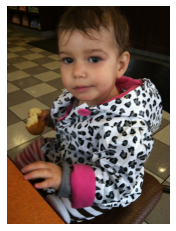

In [6]:
import matplotlib
import matplotlib.pyplot as plt

sample = matplotlib.image.imread(train_paths[2])
plt.imshow(sample)
plt.axis("off")
plt.show()

In [7]:
# 기본적인 데이터 로더
import torch
from torch.utils.data import Dataset

In [12]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import ImageDraw
from skimage.color import rgb2lab
import numpy as np

class ColoriztionDataset(Dataset):
  def __inti__(self, paths, mode='train'):
      self.mode = mode
      self.paths = paths

      if mode == "train":
        self.transforms = transforms.Compose([
            transforms.Resize((256,256), Image.BICUBIC),
            transforms.RandomHorizontalFlip()
        ])
      elif mode == "val":
        self.transform = transforms.Resize((256,256), Image.BICUBIC)
      else:
        raise Exception("train or validation only!!!!")

  def __getitem__(self, index):
      img = Image.open(self.paths[index]).convaert("RGC")
      img = np.array(self.transorms(img))
      img = rgb2lab(img).astype("floa32") # RGE 채널을 Lab채널로 변환해 주는 것!
      img = transforms.ToTensor()(img)
      L = img[[0],...] /50. -1 # -1 ~ 1 사이로 정규화 진행
      ab = img[[1,2],...] # -1 ~ 1 사이로 정규화 진행

      return {'L':L, 'ab' : ab}

  def __len__(self):
      return len(self.paths)


In [10]:
# from torch.utils.data import Dataset, DataLoader
# from torchvision import transforms
# from PIL import Image
# from skimage.color import rgb2lab, lab2rgb
# import numpy as np

# class ColorizationDataset(Dataset):
#   def __init__(self, paths, mode='train'):
#       self.mode = mode
#       self.paths = paths

#       if mode == "train":
#         self.transforms = transforms.Compose([
#             transforms.Resize((256, 256), Image.BICUBIC),
#             transforms.RandomHorizontalFlip(),
#         ])
#       elif mode == "val":
#         self.transforms = transforms.Resize((256, 256), Image.BICUBIC)
#       else:
#         raise Exception("train or validation only!!!!")
      
#   def __getitem__(self, index):
#       img = Image.open(self.paths[index]).convert("RGB")
#       img = np.array(self.transforms(img))
#       img = rgb2lab(img).astype("float32") # RGB 채널을 Lab 채널로 변환해 주는 것!
#       img = transforms.ToTensor()(img)
#       L = img[[0], ...] /50. -1 # -1 ~ 1 사이로 정규화를 진행한다.
#       ab = img[[1, 2], ...] / 110. # -1 ~ 1 사이로 정규화를 진행한다.

#       return {'L': L, 'ab': ab}

#   def __len__(self):
#       return len(self.paths)

# dataset_train = ColorizationDataset(train_paths, mode='train')
# dataset_val = ColorizationDataset(val_paths, mode='val')

# dataloader_train = DataLoader(dataset_train, batch_size=16, num_workers=2, pin_memory=True)
# dataloader_val = DataLoader(dataset_val, batch_size=16, num_workers=2, pin_memory=True)

/usr/local/lib/python3.8/dist-packages/torchvision/transforms/transforms.py:280: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(


In [13]:
dataset_train = ColorizationDataset(train_paths, mode ='train')
dataset_val = ColorizationDataset(val_paths,mode='val')

/usr/local/lib/python3.8/dist-packages/torchvision/transforms/transforms.py:280: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(


In [14]:
dataset_train= DataLoader(dataset_train, batch_size= 16, num_workers=2,pin_memory =True)
dataset_val= DataLoader(dataset_val, batch_size= 16, num_workers=2,pin_memory =True)

In [16]:
data = next(iter(dataloader_train))
Ls, abs = data['L'],data['ab']
print(Ls.shape, abs.shape)

torch.Size([16, 1, 256, 256]) torch.Size([16, 2, 256, 256])


In [24]:
import torch.nn as nn

class SRCNN(nn.Module):
  def __init__(self. num_channels=1):
    super(SRCNN,self).__ini__()

    self.conv1 = nn.Conv2d(num_channels, 64, kenel_size=9,paddnig=9//2)
    self.conv2 = nn.Conv2d(64, 32, kenel_size=5,paddnig=5//2)
    self.conv2 = nn.Conv2d(32, num_channels, kenel_size=5,paddnig=5//2)
    self.relu = nn.ReLU(inplace=True)

  def forward(self ,x):
    x= self.convl(x)
    x = self.relu()
    x = self.conv2(x)
    x = self.relu(x)
    x = self.conv3(x)

    return x

SyntaxError: ignored

In [ ]:
import skimage.color import rgb2lab, lab2rgb


class Prepoxess_Image(Dataset):
  # 생성자
  def __init__ (self, paths,mode='train'):
    self.mode=mode
    self.path=path

    # if else문으로 mode가 train인지 아닌지를 설정
    # train인 경우, 이미지 사이즈 통일하고 random horizontal flip으로 augmentation 해준다.
    # validation인 경우, 이미지 사이즈만 통일하자
    
    # trasform.Compose 선언!

    self.transforms = trainforms.Resize((256,256), Image.BiCUBIC)

  def __getitem(self, index):
    # 이미지를 불러온다.
    pil
    # 이미지를 위에서 생성한 transform에 넣어준다.
    # 이미지를 넘파이 어레이로 변환한다.
    # sklearn rgb2lab lab2rgb
    # 이미지를 텐서로 바꿔준다.
    # 정류화를 진행한다.
  return{'L' : L, 'ab': ab}

  def __len(self):
    return len(self.paths)

In [ ]:
# Load Dataset from ImageFolder
class Dataset(data.Dataset): # torch Dataset 상속받기
    def __init__(self, image_dir, direction):
        super(Dataset, self).__init__() # 초기화 상속
        self.direction = direction # 
        self.a_path = os.path.join(image_dir, "a") # a: 건물
        self.b_path = os.path.join(image_dir, "b") # b: Segmentation Mask
        self.image_filenames = [x for x in os.listdir(self.a_path)] 
        self.transform = transforms.Compose([transforms.Resize((256, 256)), # 이미지 크기
                                            transforms.ToTensor(), # Numpy -> Tensor
                                             transforms.Normalize(mean=(0.5, 0.5, 0.5), 
                                                std=(0.5, 0.5, 0.5)) # Normalization : -1 ~ 1 range
                                            ])
        self.len = len(self.image_filenames)
    
    def __getitem__(self, index):
        
        # a,b 폴더에서 불러오기
        a = Image.open(os.path.join(self.a_path, self.image_filenames[index])).convert('RGB') # 건물 사진
        b = Image.open(os.path.join(self.b_path, self.image_filenames[index])).convert('RGB') # Segmentation 사진
        
        # 이미지 전처리
        a = self.transform(a)
        b = self.transform(b)
        
        if self.direction == "a2b": # 건물 -> Segmentation
            return a, b
        else:  # Segmentation -> 건물
            return b, a
    
    def __len__(self):
        return self.len
        

In [ ]:
# train_dataset = Dataset(" ", "b2a")
# test_dataset = Dataset(" ", "b2a")

# train_loader = DataLoader(dataset=train_dataset, num_workers=0, batch_size=1, shuffle=True) # Shuffle
# test_loader = DataLoader(dataset=test_dataset, num_workers=0, batch_size=1, shuffle=False)

In [ ]:
# -1~1 → 0~1
def denorm(x):
    out = (x + 1) / 2
    return out.clamp(0, 1)

def show_images(real_a, real_b, fake_b):
    plt.figure(figsize=(30,90))
    plt.subplot(131)
    plt.imshow(real_a.cpu().data.numpy().transpose(1,2,0))
    plt.xticks([])
    plt.yticks([])
    
    plt.subplot(132)
    plt.imshow(real_b.cpu().data.numpy().transpose(1,2,0))
    plt.xticks([])
    plt.yticks([])
    
    plt.subplot(133)
    plt.imshow(fake_b.cpu().data.numpy().transpose(1,2,0))
    plt.xticks([])
    plt.yticks([])
    
    plt.show()

In [ ]:
# Conv -> Batchnorm -> Activate function Layer

def conv(c_in, c_out, k_size, stride=2, pad=1, bn=True, activation='relu'):
    layers = []
    
    # Conv layer
    layers.append(nn.Conv2d(c_in, c_out, k_size, stride, pad, bias=False))
    
    # Batch Normalization
    if bn:
        layers.append(nn.BatchNorm2d(c_out))
    
    # Activation
    if activation == 'lrelu':
        layers.append(nn.LeakyReLU(0.2))
    elif activation == 'relu':
        layers.append(nn.ReLU())
    elif activation == 'tanh':
        layers.append(nn.Tanh())
    elif activation == 'none':
        pass
    
    return nn.Sequential(*layers)

# Deconv -> BatchNorm -> Activate function Layer

def deconv(c_in, c_out, k_size, stride=2, pad=1, bn=True, activation='lrelu'):
    layers = []
    
    # Deconv.
    layers.append(nn.ConvTranspose2d(c_in, c_out, k_size, stride, pad, bias=False))
    
    # Batchnorm
    if bn:
        layers.append(nn.BatchNorm2d(c_out))
    
    # Activation
    if activation == 'lrelu':
        layers.append(nn.LeakyReLU(0.2))
    elif activation == 'relu':
        layers.append(nn.ReLU())
    elif activation == 'tanh':
        layers.append(nn.Tanh())
    elif activation == 'none':
        pass
                
    return nn.Sequential(*layers)

In [ ]:
class Generator(nn.Module):
    # initializers
    def __init__(self):
        super(Generator, self).__init__()
        # Unet encoder
        self.conv1 = conv(3, 64, 4, bn=False, activation='lrelu') # (B, 64, 128, 128)
        self.conv2 = conv(64, 128, 4, activation='lrelu') # (B, 128, 64, 64)
        self.conv3 = conv(128, 256, 4, activation='lrelu') # (B, 256, 32, 32)
        self.conv4 = conv(256, 512, 4, activation='lrelu') # (B, 512, 16, 16)
        self.conv5 = conv(512, 512, 4, activation='lrelu') # (B, 512, 8, 8)
        self.conv6 = conv(512, 512, 4, activation='lrelu') # (B, 512, 4, 4)
        self.conv7 = conv(512, 512, 4, activation='lrelu') # (B, 512, 2, 2)
        self.conv8 = conv(512, 512, 4, bn=False, activation='relu') # (B, 512, 1, 1)

        # Unet decoder
        self.deconv1 = deconv(512, 512, 4, activation='relu') # (B, 512, 2, 2)
        self.deconv2 = deconv(1024, 512, 4, activation='relu') # (B, 512, 4, 4)
        self.deconv3 = deconv(1024, 512, 4, activation='relu') # (B, 512, 8, 8) 
        self.deconv4 = deconv(1024, 512, 4, activation='relu') # (B, 512, 16, 16)
        self.deconv5 = deconv(1024, 256, 4, activation='relu') # (B, 256, 32, 32)
        self.deconv6 = deconv(512, 128, 4, activation='relu') # (B, 128, 64, 64)
        self.deconv7 = deconv(256, 64, 4, activation='relu') # (B, 64, 128, 128)
        self.deconv8 = deconv(128, 3, 4, activation='tanh') # (B, 3, 256, 256)

    # forward method
    def forward(self, input):
        # Unet encoder
        e1 = self.conv1(input)
        e2 = self.conv2(e1)
        e3 = self.conv3(e2)
        e4 = self.conv4(e3)
        e5 = self.conv5(e4)
        e6 = self.conv6(e5)
        e7 = self.conv7(e6)
        e8 = self.conv8(e7)
                              
        # Unet decoder
        d1 = F.dropout(self.deconv1(e8), 0.5, training=True)
        d2 = F.dropout(self.deconv2(torch.cat([d1, e7], 1)), 0.5, training=True)
        d3 = F.dropout(self.deconv3(torch.cat([d2, e6], 1)), 0.5, training=True)
        d4 = self.deconv4(torch.cat([d3, e5], 1))
        d5 = self.deconv5(torch.cat([d4, e4], 1))
        d6 = self.deconv6(torch.cat([d5, e3], 1))
        d7 = self.deconv7(torch.cat([d6, e2], 1))
        output = self.deconv8(torch.cat([d7, e1], 1))
        
        return output

In [ ]:
# patch 보고 판별하는 D
class Discriminator(nn.Module):
    # initializers
    def __init__(self):
        super(Discriminator, self).__init__()
        self.conv1 = conv(6, 64, 4, bn=False, activation='lrelu')
        self.conv2 = conv(64, 128, 4, activation='lrelu')
        self.conv3 = conv(128, 256, 4, activation='lrelu')
        self.conv4 = conv(256, 512, 4, 1, 1, activation='lrelu')
        self.conv5 = conv(512, 1, 4, 1, 1, activation='none')

    # forward method
    def forward(self, input):
        out = self.conv1(input)
        out = self.conv2(out)
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.conv5(out)

        return out

In [ ]:
# G, D GPU로
G = Generator().cuda()
D = Discriminator().cuda()

criterionL1 = nn.L1Loss().cuda()
criterionMSE = nn.MSELoss().cuda()

# Setup optimizer
g_optimizer = optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))
d_optimizer = optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))

In [ ]:
# Train
for epoch in range(1, 100):
    for i, (real_a, real_b) in enumerate(train_loader, 1):
        # forward
        real_a, real_b = real_a.cuda(), real_b.cuda()
        real_label = torch.ones(1).cuda()
        fake_label = torch.zeros(1).cuda()
        
        fake_b = G(real_a) # G가 생성한 fake
        
        #============= Train the discriminator =============#
        # train with fake
        fake_ab = torch.cat((real_a, fake_b), 1)
        pred_fake = D.forward(fake_ab.detach())
        loss_d_fake = criterionMSE(pred_fake, fake_label)

        # train with real
        real_ab = torch.cat((real_a, real_b), 1)
        pred_real = D.forward(real_ab)
        loss_d_real = criterionMSE(pred_real, real_label)
        
        # Combined D loss
        loss_d = (loss_d_fake + loss_d_real) * 0.5
        
        # Backprop + Optimize
        D.zero_grad()
        loss_d.backward()
        d_optimizer.step()

        #=============== Train the generator ===============#
        # First, G(A) should fake the discriminator
        fake_ab = torch.cat((real_a, fake_b), 1)
        pred_fake = D.forward(fake_ab)
        loss_g_gan = criterionMSE(pred_fake, real_label)

        # Second, G(A) = B
        loss_g_l1 = criterionL1(fake_b, real_b) * 10
        
        loss_g = loss_g_gan + loss_g_l1
        
        # Backprop + Optimize
        G.zero_grad()
        D.zero_grad()
        loss_g.backward()
        g_optimizer.step()
        
        if i % 200 == 0:
            print('======================================================================================================')
            print('Epoch [%d/%d], Step[%d/%d], d_loss: %.4f, g_loss: %.4f'
                  % (epoch, 100, i, len(train_loader), loss_d.item(), loss_g.item()))
            print('======================================================================================================')
            show_images(denorm(real_a.squeeze()), denorm(real_b.squeeze()), denorm(fake_b.squeeze()))

In [ ]:
dataset_train = Preprocess_Image(train_paths, mode= 'train')
dataloader_train = DataLoader(dataset_train, )